In [1]:
import torch
import torch.nn as nn

# Generator

In [2]:
from generator import Generator

# Discriminator

In [3]:
from discriminator import Discriminator

# Training

In [4]:
# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 1e-4

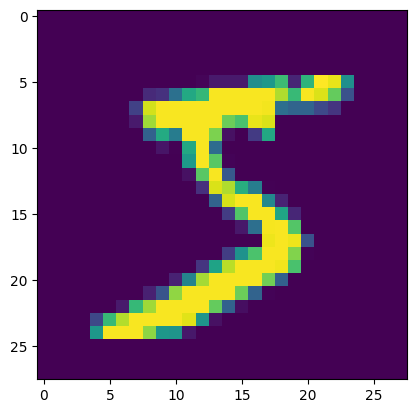

In [5]:
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets

# First, download the mnist dataset
mnist_dataset = datasets.MNIST(
    'data', 
    train=True, 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# Display an image
plt.imshow(mnist_dataset[0][0].squeeze())
plt.show()


In [8]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Hyperparameters
num_channels = 1
noise_dim = 100
image_dim = 28

# Initialize the generator and discriminator
generator = Generator(num_channels, noise_dim, image_dim).to(device)
discriminator = Discriminator(num_channels, image_dim).to(device)

# Define train loader
train_loader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
)

# Define optimizers
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.BCELoss().to(device)


# Training loop
# for epoch in range(num_epochs):
for epoch in range(1):
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move the data to the device
        data = data.to(device)

        # Define the valid and fake labels
        valid = torch.ones(batch_size, 1, 28, 28).to(device) # The discriminator should output 1 for real data
        fake = torch.zeros(batch_size, 1, 28, 28).to(device) # The discriminator should output 0 for fake data

        # Generate a batch of noise vectors for the generator
        noise_vector = torch.randn(batch_size, 100).to(device) 

        ### Train the Generator ###
        optimizer_generator.zero_grad()

        # Generate a batch of fake images
        generated_images = generator(noise_vector)

        # See how well the discriminator thinks the generated images are real
        gen_loss = criterion(discriminator(generated_images), valid)

        # Backpropagate the generator loss
        gen_loss.backward()
        optimizer_generator.step()

        ############################################################

        ### Train the Discriminator ###
        optimizer_discriminator.zero_grad()

        # Get the discriminator's prediction on the real data
        real_pred = discriminator(data)
        real_loss = criterion(real_pred, valid)

        # Get the discriminator's prediction on the fake data
        fake_pred = discriminator(generated_images)
        fake_loss = criterion(fake_pred, fake)

        # Combine the losses
        combined_loss = (real_loss + fake_loss) / 2

        # Backpropagate the combined loss
        combined_loss.backward()
        optimizer_discriminator.step()


Using device: cuda


RuntimeError: shape '[1, 4096]' is invalid for input of size 524288